# **K-Means with Numpy only**

In [286]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

import pickle # save and load centroids

## **Dataset**

In [287]:
dataset_path = "/content/dataset/housing_market_segmentation_dataset_1200.csv"
random_init_n = 4
k = 2

In [288]:
df = pd.read_csv(dataset_path)
df.head()

,Area,Rooms,BuildingAge,DistanceToCenter,Floor,Elevator,Parking
0,186,6,29,2.35,12,1,0
1,82,2,20,15.05,4,0,0
2,98,1,28,6.58,3,0,0
3,187,4,25,4.56,6,1,0
4,87,2,11,0.85,0,0,1


In [289]:
x = df.to_numpy() # features
# y = x[:, -1] >>> In this dataset we have no labels!

## **Custom Methods**

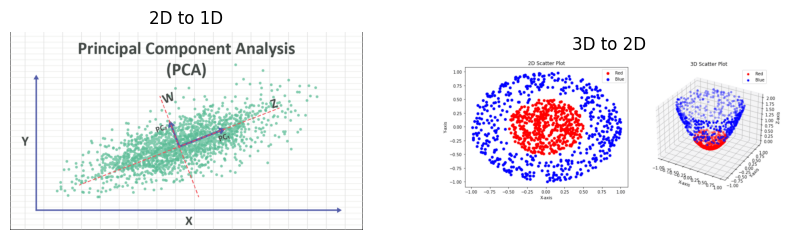

In [290]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=0)
    return (X - mean) / (std + 1e-8)

def pca(X, k_dim=2):
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    top_k_eigenvectors = eigenvectors[:, idx[:k_dim]]
    X_pca = X.dot(top_k_eigenvectors)

    return X_pca, top_k_eigenvectors


# Principal Component Analysis (PCA): <dimension reduction>
img1 = img.imread("/content/2d-to-1d-dim-reduc-pca-image-by-numxl.png")
img2 = img.imread("/content/3d-to-2d-dim-reduc-pca-image-by-baeldung.png")

ig = plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("2D to 1D")

plt.subplot(2, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("3D to 2D")

plt.show()

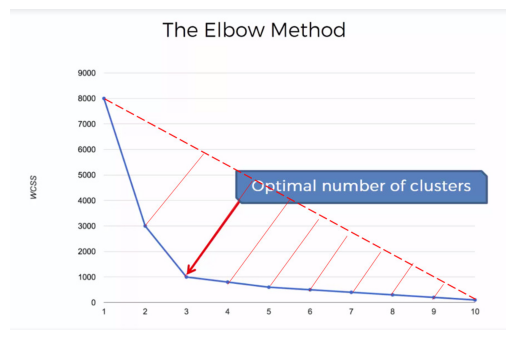

In [291]:
def inertia(X, labels, centroids):
    """ Elbow Method """
    total = 0
    for i, x in enumerate(X):
        c = centroids[labels[i]]
        total += np.sum((x - c) ** 2)
    return total


elbow_img = img.imread("elbow-method-image-by-asanka-perera.jpg")
plt.axis("off")
plt.imshow(elbow_img)

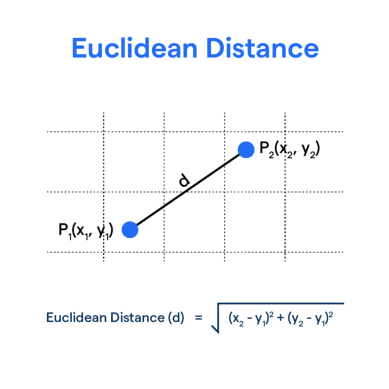

In [292]:
def euclidean_distance(X, centroids):
    return np.sqrt(((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2))


img_euc = img.imread("euclidean-distance-image-by-botpenguin.png")
plt.axis("off")
plt.imshow(img_euc)

In [293]:
def kmeans(X, k, max_iters=100):
    n_samples, n_features = X.shape

    # random centroids
    idx = np.random.choice(n_samples, k, replace=False)
    centroids = X[idx]

    for _ in range(max_iters):
        distances = euclidean_distance(X, centroids)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            X[labels == i].mean(axis=0) for i in range(k)
        ])

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

## **Preprocessing**

In [294]:
# --- Feature Scaling
x_scaled = standardize(x)

# --- Dimension Reduction
X, top_k_eigenvectors = pca(x_scaled)

## **Evaluation**

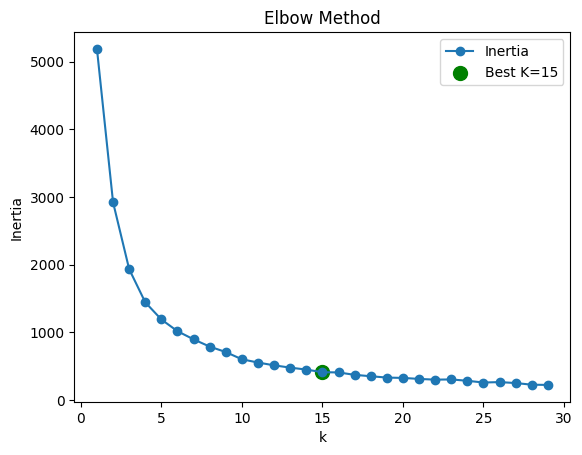

In [295]:
# prediction with euclidean function + Elbow Method for find best k
inertias = []

for k in range(1, 30):
    labels, centroids = kmeans(X, k)
    inertias.append(inertia(X, labels, centroids))

best_k = 2
best_inertia = inertias[0]

for i in range(1, len(inertias)-1):
    diff1 = inertias[i-1] - inertias[i]
    diff2 = inertias[i] - inertias[i+1]
    if diff2 < 0.1 * diff1:
        best_k = i + 1
        best_inertia = inertias[i]
        break

best_labels, best_centroids = kmeans(X, best_k)

plt.plot(range(1,30), inertias, marker='o', label="Inertia")
plt.scatter(best_k, best_inertia, color='green', s=100, label=f"Best K={best_k}")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.legend()
plt.show()

In [296]:
# Saving...
with open("kmeans_centroids.pkl", "wb") as f:
    pickle.dump(best_centroids, f)


## Analysis & Visualization

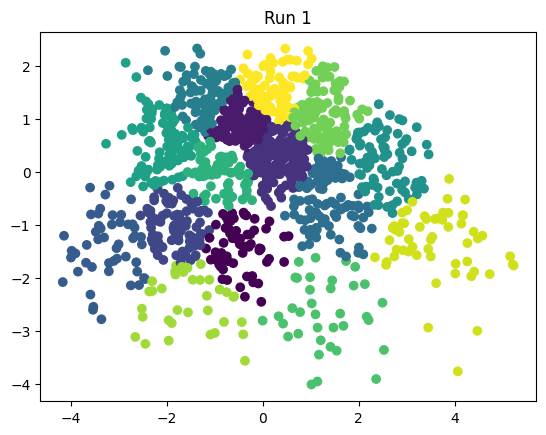

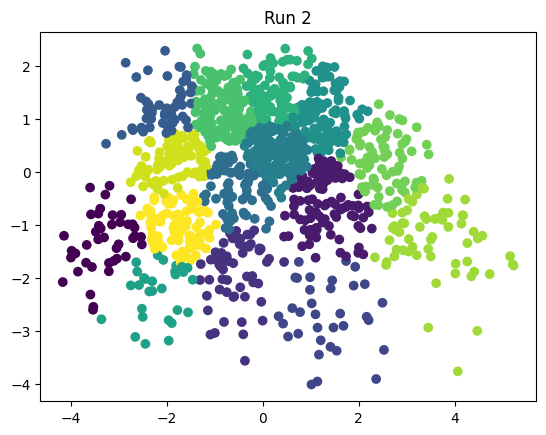

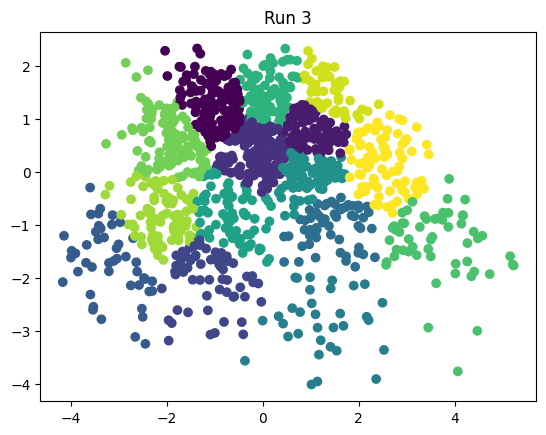

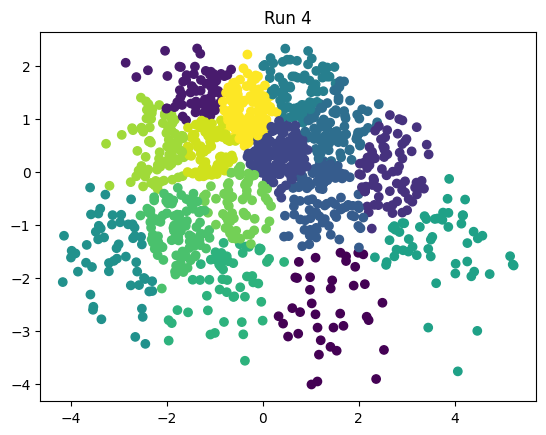

In [297]:
# random initialization
for i in range(random_init_n):
    test_labels, _ = kmeans(X, best_k)
    plt.scatter(X[:,0], X[:,1], c=test_labels)
    plt.title(f"Run {i+1}")
    plt.show()

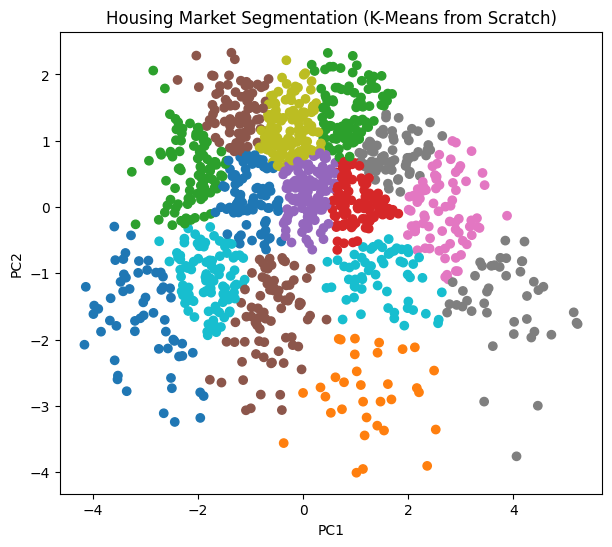

In [298]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=best_labels, cmap="tab10")
plt.title("Housing Market Segmentation (K-Means from Scratch)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

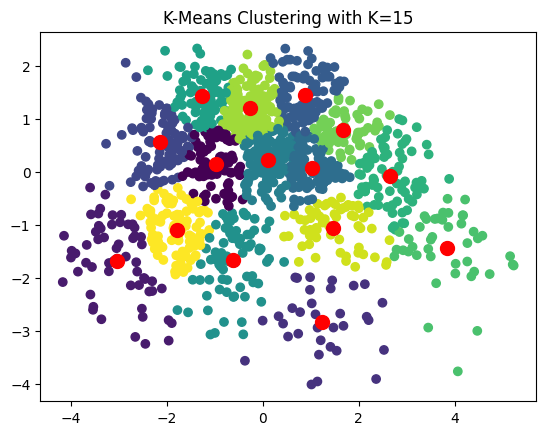

In [299]:
plt.scatter(X[:,0], X[:,1], c=best_labels, cmap='viridis')
plt.scatter(best_centroids[:,0], best_centroids[:,1], color='red', marker='o', s=100)
plt.title(f"K-Means Clustering with K={best_k}")
plt.show()

## **Table Analysis**

In [300]:
df["cluster"] = best_labels
summary_display = df.groupby("cluster").mean().round({
    "Area": 2,
    "Rooms": 0,
    "BuildingAge": 0,
    "DistanceToCenter": 2,
    "Floor": 0
}).drop(columns=["Elevator", "Parking"])

summary = df.groupby("cluster").mean().round(2)
summary_display["Elevator_%"] = (summary["Elevator"] * 100).round(1)
summary_display["Parking_%"] = (summary["Parking"] * 100).round(1)

summary_display

,Area,Rooms,BuildingAge,DistanceToCenter,Floor,Elevator_%,Parking_%
cluster,,,,,,,
0,147.43,4.0,19.0,2.92,5.0,5.0,72.0
1,184.76,5.0,17.0,1.96,9.0,100.0,84.0
2,113.55,3.0,31.0,14.02,7.0,76.0,3.0
3,174.24,5.0,13.0,1.64,5.0,7.0,91.0
4,93.79,2.0,14.0,2.65,1.0,0.0,47.0
5,113.00,3.0,23.0,6.50,3.0,0.0,17.0
6,127.45,3.0,19.0,4.62,4.0,3.0,42.0
7,135.48,4.0,23.0,5.59,7.0,84.0,41.0
8,150.46,5.0,12.0,1.29,2.0,0.0,92.0


## **Inference**

In [301]:
x_new = np.array([
    120,  # Area
    3,    # Rooms
    10,   # BuildingAge
    5.0,  # DistanceToCenter
    4,    # Floor
    1,    # Elevator
    1    # Parking
])

In [302]:
x_new_scaled = standardize(x_new)
x_new_pca = x_new_scaled.dot(top_k_eigenvectors)

In [303]:
# Loading...
with open("kmeans_centroids.pkl", "rb") as f:
    centroids = pickle.load(f)

In [304]:
# inference with new data
y = np.argmin(np.sum((centroids - x_new_pca)**2, axis=1))
print("label:", y)

label: 0
